In [1]:
import yaml
from typing import List

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

import torch
from yolov5.utils.datasets import create_dataloader

### 1. Loading and checking default hyperparameters of YOLOv5:

In [2]:
with open('hyp.yaml', 'r') as f:
    hyp = yaml.safe_load(f)

hyp

{'lr0': 0.002,
 'lrf': 0.2,
 'momentum': 0.937,
 'weight_decay': 0.005,
 'warmup_epochs': 3.0,
 'warmup_momentum': 0.8,
 'warmup_bias_lr': 0.1,
 'box': 0.05,
 'cls': 0.5,
 'cls_pw': 1.0,
 'obj': 1.0,
 'obj_pw': 1.0,
 'iou_t': 0.2,
 'anchor_t': 4.0,
 'fl_gamma': 0.0,
 'hsv_h': 0.015,
 'hsv_s': 0.7,
 'hsv_v': 0.4,
 'degrees': 0.0,
 'translate': 0.1,
 'scale': 0.5,
 'shear': 0.0,
 'perspective': 0.0,
 'flipud': 0.0,
 'fliplr': 0.5,
 'mosaic': 1.0,
 'mixup': 0.0,
 'copy_paste': 0.0}

### 2. Extracting parameters related to augmentations only (I manually tuned some default values):

In [3]:
all_augs = {
    'hsv_h': 0.015,
    'hsv_s': 0.7,
    'hsv_v': 0.4,
    'degrees': 20,
    'translate': 0.3,
    'scale': 0.3,
    'shear': 5,
    'perspective': 0.0005,
    'flipud': 1,
    'fliplr': 1,
    'mosaic': 0.5,
    'mixup': 0.5,
    'copy_paste': 0.5
}
len(all_augs)

13

### 3. Creating batches of images with each of the 13 augmentations:

In [4]:
def get_augmented_batch(hyp: dict, all_augs: dict, target_aug: str = None
                       ) -> List[torch.Tensor]:
    '''
    Returns batch augmented with target_aug.
    '''
    # cancel all augs except for the target_aug
    hyp = hyp.copy()
    for aug in all_augs:
        if aug == target_aug:
            hyp[aug] = all_augs[aug]
        else:
            hyp[aug] = 0
            
    if target_aug == 'mixup':
        hyp['mosaic'] = 1 # (mixup works only with mosaic)
            
    # create dataloader
    dataloader, dataset = create_dataloader(
        path='data/splits/aug_imgs.txt',
        imgsz=640,
        batch_size=4,
        hyp=hyp,
        stride=1,
        augment=True,
        rect=False,
        workers=1
    )
    dataloader_it = iter(dataloader)
    batch = next(dataloader_it)   
    return batch[:2]

In [6]:
augmented_batches = {}

for target_aug in all_augs:
    batch = get_augmented_batch(hyp, all_augs, target_aug)
    augmented_batches[target_aug] = batch

### 4. Visual inspection of augmentations effects:

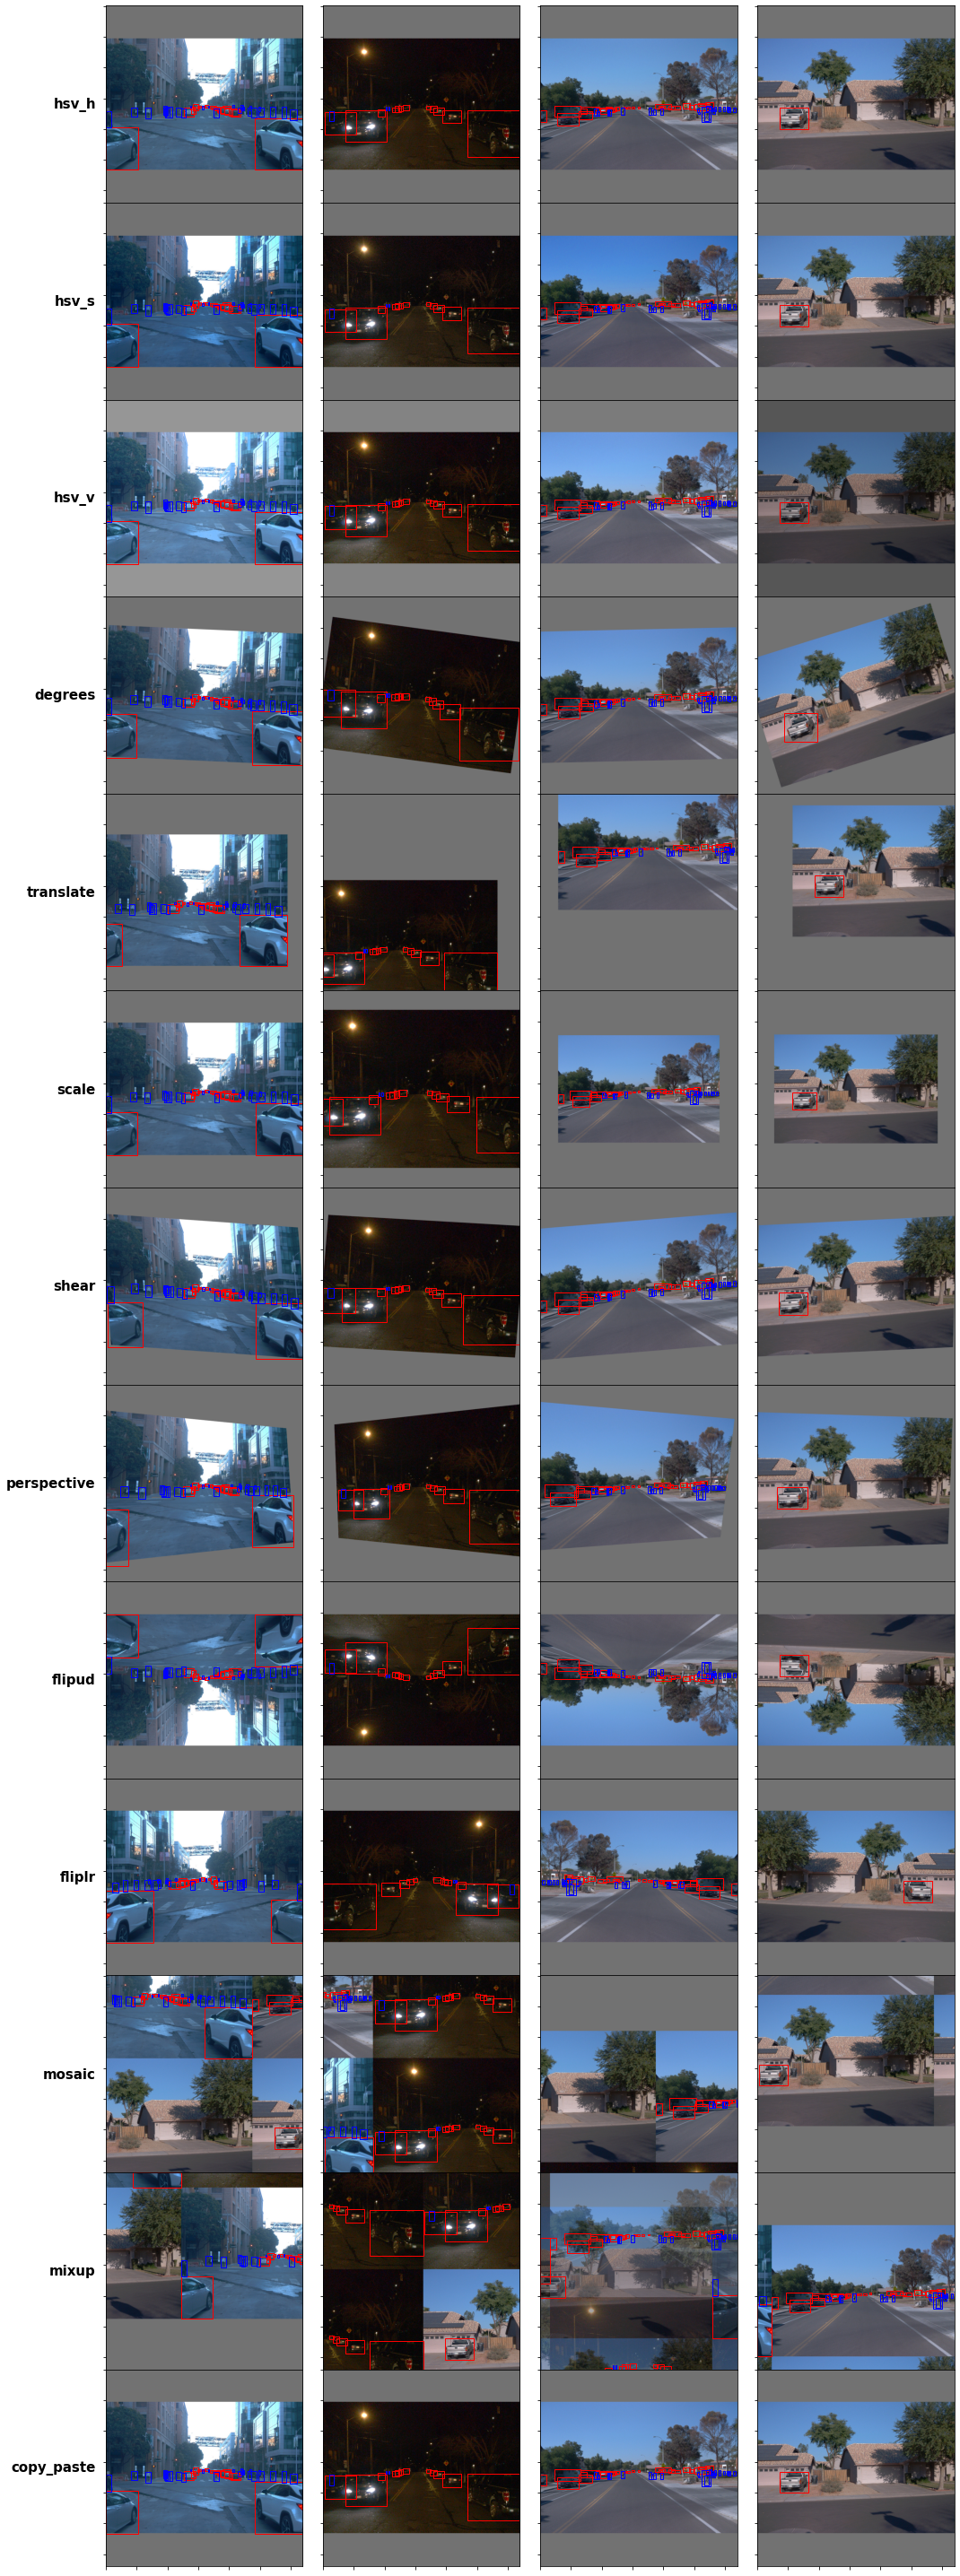

In [8]:
fig, axes = plt.subplots(len(all_augs), 4, figsize=(15, 40))
colors = ['red', 'blue', 'green']

for row, target_aug in enumerate(all_augs):
    batch = augmented_batches[target_aug]
    imgs, targets = batch
    
    height, width = imgs.shape[2:]
    targets = targets.numpy().copy()
    targets[:, [2, 4]] *= width
    targets[:, [3, 5]] *= height    
    
    for col, img in enumerate(imgs):
        ax = axes[row, col]
        ax.imshow(img.permute(1, 2, 0))
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        
        bboxes = targets[targets[:, 0] == col][:, 1:]
        for label_id, xc, yc, w, h in bboxes:
            x, y = xc - w/2, yc - h/2
            color = colors[int(label_id)]
            rec = Rectangle((x, y), w, h, facecolor='none', 
                            edgecolor=color)
            ax.add_patch(rec)
    
    axes[row, 0].set_ylabel(target_aug, fontweight='bold', fontsize=15,
                          ha='right', va='center', rotation=0)
    
fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)        

<font size=4>

- [x] **HSV distortion:** would certainly need that
- [ ] **degrees:** don't see much sense in this kind of rotation here
- [ ] **translate:** could be effectively replaced by **mosaic**, which doesn't cause such waste of computation
- [x] **scale, shear, perspective:** makes sense
- [ ] **flipud:** totally no
- [x] **fliplr, mosaic, mixup:** totally yes
- [ ] **copy_paste:** no visible effect (may be some bug in implementation)
</font>